## Part 7 - Executing with Live Data

In [1]:

from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
#connect database
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'11207471' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [2]:
db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")

In [3]:
# get live data

schema = r'raw'
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,chicago_airbnb
1,chicago_airbnb_live_data
2,chicago_data_cleaning_preprocess
3,chicago_data_cleaning_preprocess_2
4,global_warming


In [4]:
table_name = r'chicago_airbnb_live_data'
sql=r'SELECT * FROM ' + schema + '.' + table_name
live = pd.read_sql(sql, db_conn, index_col=None)

In [5]:
live.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,22086468,"Style, comfort & class",159752521,Moraima,None,West Town,41.90372,-87.69651,Private room,29,3,41,2020-03-18,1.34,1,14
1,3953880,Spacious Bedroom in E. Rogers Park,20494609,Chad,None,Rogers Park,42.00493,-87.66471,Private room,80,3,27,2019-12-15,0.54,2,355
2,25984142,"★★★Charming 2BR near downtown, +FREE parking★★★",151133847,Candace,None,West Town,41.89355,-87.66210,Entire home/apt,129,3,57,2020-08-31,2.10,3,235
3,21695306,"LAKEVIEW HEART! BOYSTOWN -WRIGLEY ""HOSTEL STYL...",154630260,Ody,None,Lake View,41.94055,-87.65429,Shared room,51,2,0,None,NaN,18,0
4,21189762,Lakeview apartment (Wrigley area),153025288,George,None,Lake View,41.93411,-87.66960,Entire home/apt,150,2,2,2017-10-22,0.06,1,0


In [6]:
table_name = r'chicago_data_cleaning_preprocess_2'
sql=r'SELECT * FROM ' + schema + '.' + table_name
preprocess = pd.read_sql(sql, db_conn, index_col=None)

In [8]:
preprocess

,field_name,action,values
0,id,drop,None
1,name,drop,None
2,host_id,drop,None
3,host_name,drop,None
4,last_review,drop,None
5,neighbourhood_group,drop,None
6,reviews_per_month,remove_missing,None
7,price,remove_outliers,"lower_threshold: -72.5, upper_threshold: 283.5"
8,room_type,one_hot_encode,"Entire home/apt, Hotel room, Private room, Sha..."
9,neighbourhood,one_hot_encode,"Albany Park, Archer Heights, Armour Square, As..."


**User Defined function**

In [9]:
import pandas as pd
import numpy as np

def preprocess_live_data(data):
    
    # Drop unnecessary columns
    columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood_group']
    data.drop(columns=columns_to_drop, inplace=True)
    
    # Drop any rows with missing values
    data.dropna(inplace=True)
    
    # Remove outliers in 'price' (thresholds: 0 to 283.5)
    data = data[(data['price'] >= 0) & (data['price'] <= 283.5)]
    
    # One-hot encode 'room_type' and 'neighbourhood' columns
    data = pd.get_dummies(data, columns=['room_type', 'neighbourhood'])
    
    # Create new column 'booking_frequency' (number_of_reviews / availability_365)
    data['booking_frequency'] = data['number_of_reviews'] / data['availability_365']
    
    # If 'availability_365' is 0, set 'booking_frequency' to 0
    data['booking_frequency'] = data['booking_frequency'].replace([np.inf, -np.inf], np.nan)
    
    # Fill any NaN values in 'booking_frequency' with 0
    data['booking_frequency'] = data['booking_frequency'].fillna(0)

    # Create new column 'price_per_room' (price / minimum_nights)
    data['price_per_room'] = data['price'] / data['minimum_nights']
    
    # Return the processed data
    return data


In [10]:
cleaned_data = preprocess_live_data(live)

In [11]:
cleaned_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,...,neighbourhood_Norwood Park,neighbourhood_Portage Park,neighbourhood_Rogers Park,neighbourhood_South Chicago,neighbourhood_Uptown,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,booking_frequency,price_per_room
0,41.90372,-87.69651,29,3,41,1.34,1,14,False,True,...,False,False,False,False,False,False,True,False,2.928571,9.666667
1,42.00493,-87.66471,80,3,27,0.54,2,355,False,True,...,False,False,True,False,False,False,False,False,0.076056,26.666667
2,41.89355,-87.66210,129,3,57,2.10,3,235,True,False,...,False,False,False,False,False,False,True,False,0.242553,43.000000
4,41.93411,-87.66960,150,2,2,0.06,1,0,True,False,...,False,False,False,False,False,False,False,False,0.000000,75.000000
6,41.79592,-87.58044,79,1,115,4.20,62,79,True,False,...,False,False,False,False,False,False,False,False,1.455696,79.000000


In [16]:
import joblib

loaded_model = joblib.load('optimal_model.joblib')

In [18]:
feature_cols = ['price_per_room', 'minimum_nights', 'room_type_Entire home/apt',
                'reviews_per_month','availability_365','longitude','latitude',
                'calculated_host_listings_count','booking_frequency','number_of_reviews',
                'neighbourhood_Uptown']

predictions = loaded_model.predict(cleaned_data[feature_cols])

In [19]:
print("Predictions for the live data:", predictions)

Predictions for the live data: [ 32.   81.  129.7 150.   79.   68.8 127.1  86.1  50.   88.4 234.4 171.7
  59.  135.  130.   37.8 205.2 215.  132.3  50.  154.9  84.8  90.  249.1
 111.   35.   75.  200.   69.9 175.4 157.2  75.   43.5  73.8  22.4  99.
 149.8 118.5  96.1 100.1  74.3 120.   50.  148.6  56.8  85.  102.9 195.1
  80.   47.3 104.6  76.8  77.1  68.  174.7  42.8 173.1  33.7 117.8 140.9
 206.9 103.   80.   50.  146.2 129.  130.4  59.  202.2 146.1  93.3  65.
  68.8 199.9  49. ]


In [21]:
predictions.shape

(75,)

In [22]:
cleaned_data.shape

(75, 43)

#### append predicion to raw live data 

In [23]:

cleaned_data['predicted_price'] = predictions

In [24]:
cleaned_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,...,neighbourhood_Portage Park,neighbourhood_Rogers Park,neighbourhood_South Chicago,neighbourhood_Uptown,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,booking_frequency,price_per_room,predicted_price
0,41.90372,-87.69651,29,3,41,1.34,1,14,False,True,...,False,False,False,False,False,True,False,2.928571,9.666667,32.0
1,42.00493,-87.66471,80,3,27,0.54,2,355,False,True,...,False,True,False,False,False,False,False,0.076056,26.666667,81.0
2,41.89355,-87.66210,129,3,57,2.10,3,235,True,False,...,False,False,False,False,False,True,False,0.242553,43.000000,129.7
4,41.93411,-87.66960,150,2,2,0.06,1,0,True,False,...,False,False,False,False,False,False,False,0.000000,75.000000,150.0
6,41.79592,-87.58044,79,1,115,4.20,62,79,True,False,...,False,False,False,False,False,False,False,1.455696,79.000000,79.0


In [25]:
schema = r'analytics'
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,model1_validation_predict


In [26]:
table_name = r'chicago_airbnb_live_data_prcessed'
cleaned_data.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

75

In [27]:
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,chicago_airbnb_live_data_prcessed
1,model1_validation_predict


# screenshot of PgAdmin showing newly created table
![pgAdmin image](screenshot5.png)

#### compare actual price to predicte dprice

- To compare the actual price with the price predicted by the model, we subtract the predicted price from the actual price and then divide the result by the actual price. By multiplying the whole equation by 100, we get the percentage by which each predicted price is off.

- In the end, on average, we find that the predicted price differs from the actual price by 2.871%.

In [28]:
cleaned_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,room_type_Private room,...,neighbourhood_Portage Park,neighbourhood_Rogers Park,neighbourhood_South Chicago,neighbourhood_Uptown,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,booking_frequency,price_per_room,predicted_price
0,41.90372,-87.69651,29,3,41,1.34,1,14,False,True,...,False,False,False,False,False,True,False,2.928571,9.666667,32.0
1,42.00493,-87.66471,80,3,27,0.54,2,355,False,True,...,False,True,False,False,False,False,False,0.076056,26.666667,81.0
2,41.89355,-87.66210,129,3,57,2.10,3,235,True,False,...,False,False,False,False,False,True,False,0.242553,43.000000,129.7
4,41.93411,-87.66960,150,2,2,0.06,1,0,True,False,...,False,False,False,False,False,False,False,0.000000,75.000000,150.0
6,41.79592,-87.58044,79,1,115,4.20,62,79,True,False,...,False,False,False,False,False,False,False,1.455696,79.000000,79.0


In [31]:
# percentage difference

cleaned_data['percentage_difference'] = (abs(cleaned_data['price'] - cleaned_data['predicted_price']) / cleaned_data['price']) * 100


average_percentage_difference = cleaned_data['percentage_difference'].mean()
print(average_percentage_difference)


2.8711550686544203


In [33]:
cleaned_data[['price', 'predicted_price', 'percentage_difference']]

,price,predicted_price,percentage_difference
0,29,32.0,10.344828
1,80,81.0,1.250000
2,129,129.7,0.542636
4,150,150.0,0.000000
6,79,79.0,0.000000
...,...,...,...
94,98,93.3,4.795918
95,65,65.0,0.000000
96,69,68.8,0.289855
97,200,199.9,0.050000


# Part 9 - Insight

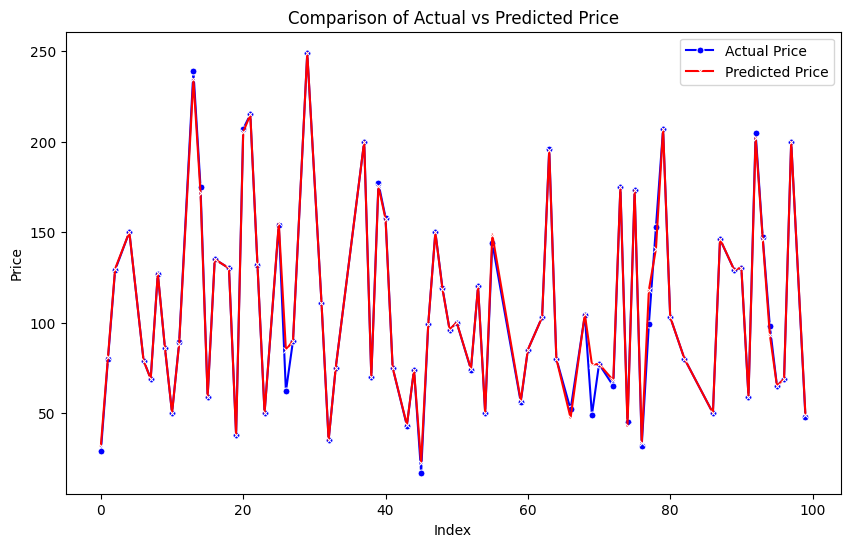

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.lineplot(x=cleaned_data.index, y=cleaned_data['price'], color='blue', label='Actual Price', marker='o', markersize=5)
sns.lineplot(x=cleaned_data.index, y=cleaned_data['predicted_price'], color='red', label='Predicted Price', marker='x', markersize=5)

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Comparison of Actual vs Predicted Price')

plt.legend()
plt.show()

- After creating a model to determine the factors that influence nightly rental prices on Airbnb in Chicago and how these factors can be used to estimate a competitive price for a given property, we identified key features such as:

    - price_per_room
    - minimum_nights
    - room_type_Entire home/apt
    - reviews_per_month
    - availability_365
    - longitude
    - latitude
    - calculated_host_listings_count
    - booking_frequency
    - number_of_reviews
    - neighbourhood_Uptown
    
- These are important considerations when setting up an Airbnb listing.

- Our model performs well in utilizing these features to help determine the right price for a nightly rental property, with an average deviation of only 2% from the actual price.

- Above, our graph represents how well the model predicted rental prices compared to the actual rental prices of the properties.

# part 10 - Reflection 

-  What I found to be difficult during this project was the data cleaning process and ensuring that proper preprocessing was applied to the live data.The part I enjoyed the most was tracking the steps I took with my initial dataset, creating a preprocessing pipeline, and then seeing how it worked with live data.After going through the entire process of creating this project, I now have a deeper understanding of the steps required to deploy a model into production. I believe there is still room for improvement in my model.In class, we discussed how even small percentage differences in accuracy are important to engineers, and I found myself considering the same thing throughout this project.